In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wfdb  # For å lese .dat og .hea filer
from config import DATASET_DIR
from skmultilearn.model_selection import iterative_train_test_split

# Define dataset directory
DATASET_DIR = "/Users/haaler/Downloads/UiB Master 2nd Semester/DAT255 Folder/1D-CNN_For_ECG_measurements/physionet.org/files/ptb-xl/1.0.3/"

## Download the data
This dataset is very large, will take several hours to download.

In [ ]:
!curl -O https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

In [ ]:
!unzip -q ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
!ls

## Preprocessing

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


Duration of ECG signal: 10.0 seconds


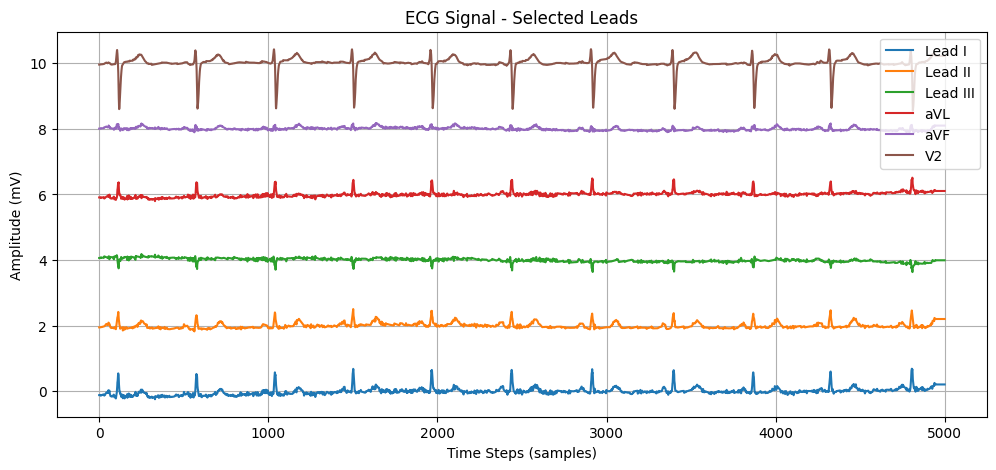

Distribution of diagnostic classes:
NORM: 9438.0 samples (43.30%)
MI: 5214.0 samples (23.92%)
STTC: 5526.0 samples (25.35%)
CD: 5752.0 samples (26.39%)
HYP: 2405.0 samples (11.03%)


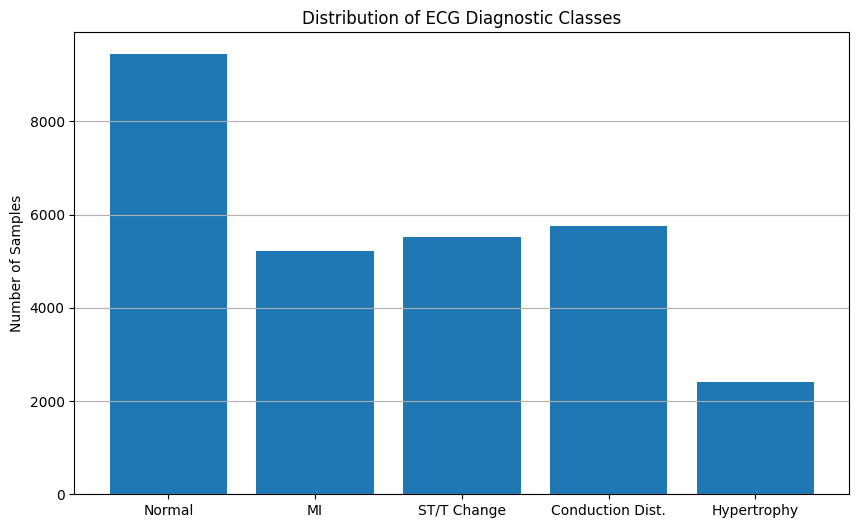

Number of multi-label records: 5558 (25.50%)


In [ ]:
### **1️⃣ Load Dataset**
# Load metadata
df = pd.read_csv(os.path.join(DATASET_DIR, "ptbxl_database.csv"))
df_labels = pd.read_csv(os.path.join(DATASET_DIR, "scp_statements.csv"))

# Display dataset information
display(df.head())



### **2️⃣ Load & Preprocess ECG Signals Efficiently**
def load_ecg(record_name):
    """Loads ECG signal from PTB-XL .dat files."""
    file_path = os.path.join(DATASET_DIR, record_name)
    record = wfdb.rdsamp(file_path)[0]  # Extract raw ECG signal
    return record

# Load all ECGs into a NumPy array
ecg_signals = np.array([load_ecg(f) for f in df["filename_hr"]])

# Display duration of ECG signals
sampling_rate = 500  # PTB-XL default sampling rate
duration = ecg_signals.shape[1] / sampling_rate
print(f"Duration of ECG signal: {duration} seconds")



### **3️⃣ Select Relevant Leads**
FOCUS_LEADS = [0, 1, 2, 4, 5, 7]  # Lead I, Lead II, Lead III, aVL, aVF, V2
FOCUS_LEAD_NAMES = ["Lead I", "Lead II", "Lead III", "aVL", "aVF", "V2"]

# Extract only the selected leads
ecg_signals = ecg_signals[:, :, FOCUS_LEADS]



### **4️⃣ Visualize ECG Signals**
def plot_ecg(ecg_data, leads, title):
    """Plots ECG signals for selected leads with offsets."""
    plt.figure(figsize=(12, 5))
    for i in range(ecg_data.shape[1]):
        plt.plot(ecg_data[:, i] + (i * 2), label=leads[i])  # Offset each lead
    plt.title(title)
    plt.xlabel("Time Steps (samples)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot selected leads
plot_ecg(ecg_signals[0], FOCUS_LEAD_NAMES, "ECG Signal - Selected Leads")



### **5️⃣ Normalize ECG Signals**
# Normalize ECGs using vectorized StandardScaler
scaler = StandardScaler()
ecg_signals = np.array([scaler.fit_transform(ecg) for ecg in ecg_signals])



### **6️⃣ Zero-Padding & Truncating**
def preprocess_ecg(ecg_data, target_length=5000):
    """Ensure all ECG signals have the same length through zero-padding or truncation."""
    current_length = ecg_data.shape[0]
    if current_length > target_length:
        return ecg_data[:target_length, :]
    elif current_length < target_length:
        padded = np.zeros((target_length, ecg_data.shape[1]), dtype=ecg_data.dtype)
        padded[:current_length, :] = ecg_data
        return padded
    return ecg_data

# Apply padding/truncation in a single NumPy operation
ecg_signals = np.array([preprocess_ecg(ecg) for ecg in ecg_signals])



### **7️⃣ Multi-Label Disease Annotations (Optimized)**
def process_labels_optimized(df, df_labels):
    """Efficiently process multi-label disease annotations using merge instead of looping."""
    diagnostic_classes = ["NORM", "MI", "STTC", "CD", "HYP"]
    df["scp_codes"] = df["scp_codes"].apply(eval)
    expanded_rows = []
    for idx, row in df.iterrows():
        for code, value in row["scp_codes"].items():
            expanded_rows.append({"ecg_id": row["ecg_id"], "scp_code": code, "confidence": value})
    expanded_df = pd.DataFrame(expanded_rows)
    expanded_df = expanded_df.merge(df_labels, left_on="scp_code", right_on="Unnamed: 0", how="left")
    expanded_df = expanded_df[(expanded_df["confidence"] >= 50) & (expanded_df["diagnostic_class"].isin(diagnostic_classes))]
    df_labels_onehot = expanded_df.pivot_table(index="ecg_id", columns="diagnostic_class", aggfunc="size", fill_value=0)
    df = df.merge(df_labels_onehot, left_on="ecg_id", right_index=True, how="left").fillna(0)
    return df

# Apply label processing
df = process_labels_optimized(df, df_labels)

# Extract labels
target_columns = ["NORM", "MI", "STTC", "CD", "HYP"]
y = df[target_columns].values.astype(np.float32)

# Distribution of diagnostic classes
print("Distribution of diagnostic classes:")
for diagnostic_class in target_columns:
    count = df[diagnostic_class].sum()
    percent = 100 * count / len(df)
    print(f"{diagnostic_class}: {count} samples ({percent:.2f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts = [df[col].sum() for col in target_columns]
plt.bar(["Normal", "MI", "ST/T Change", "Conduction Dist.", "Hypertrophy"], label_counts)
plt.title("Distribution of ECG Diagnostic Classes")
plt.ylabel("Number of Samples")
plt.grid(axis="y")
plt.show()

# Count number of multi-label cases
multi_label_count = (df[target_columns].sum(axis=1) > 1).sum()
print(f"Number of multi-label records: {multi_label_count} ({100*multi_label_count/len(df):.2f}%)")

In [4]:
# Convert DataFrame to NumPy arrays for model training
def convert_to_numpy(ecg_signals, df, target_columns):
    """Convert ECG signals and labels to NumPy arrays."""
    X = np.array(ecg_signals)
    y = df[target_columns].values
    return X, y

# Convert to NumPy arrays
X, y = convert_to_numpy(ecg_signals, df, target_columns)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (21799, 5000, 6)
Shape of y: (21799, 5)


In [5]:
# Split dataset into Train/Validation/Test Sets
y = y.astype(np.float32)

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.4)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (13079, 5000, 6), (13079, 5)
Validation set shape: (4360, 5000, 6), (4360, 5)
Testing set shape: (4360, 5000, 6), (4360, 5)
